In [3]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time

In [4]:
######################################################
# Specify the service intensity, where n is the number 
# of users in the system and c the number of servers
def service_intensity(mu,n,c):
    # returns the service intensity
    return mu * min(n, c)
######################################################
C,lambd,mu,N0 = 3,4,2,2
print("Service Intensity when mu=%d, N0=%d, C=%d: %d" % (mu,N0,C,service_intensity(mu,N0,C)))

Service Intensity when mu=2, N0=2, C=3: 4


In [5]:
# Basic M/M/C queue

def MMC(C=3,lambd=4,mu=2.,N0=0,Tmax=100):
    T             = [0]  # list of instants of events
    N             = [N0] # initial state of the system
    # arrival times of clients in the system,
    # arbitrarily set to -1 for clients present at t=0
    arrival_times = [-1 for k in range(N0)] 
    D             = [] # times spent by users inside the system
    
    while T[-1]<Tmax:
        ##########################################
        # Complete the code
        mu_state  = service_intensity(mu, N[-1], C) # current service intensity
        
        # if empty, we can only have an arrival
        if N[-1]==0:
            # inter-events delay for empty buffer:
            tau     = -1./lambd*log(rand()) 
            event = 1
            
        # if not empty, we can have an arrival or a departure
        else:
            # inter-events delay for non-empty buffer:
            tau     = -1./(lambd + mu_state)*log(rand()) 
            p_arrival = lambd / (lambd + mu_state)
            # event =+1 for an arrival, =-1 for a departure:
            event = 2*(rand()<p_arrival)-1 # +1 for an arrival, -1 for a departure
        
        N.append(N[-1]+event)
        T.append(T[-1]+tau)
        
        if event == 1:
            arrival_times.append(T[-1])
        else:
            # entry time of client going out the system:
            T_in = arrival_times.pop(0)
            if T_in>0:
                D.append(T[-1] - T_in)
        ############################################        
    T  = T[:-1] # event after Tmax is discarded
    N  = N[:-1]
    return T,N,D

In [6]:
T,N,D = MMC(Tmax=1000)
#----
V2 = mean(D)
print(V2)

0.7027358379560755


In [7]:
def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 9999

Customer = namedtuple("Customer", "service_time time_remaining arrival_time")
# example: c = Customer(service_time = 1, time_remaining = 0.5, arrival_time = 2)

def printarray(a):
    print(np.around(a, 3))
    
def customer(service_time=inf(), time_remaining=inf(), arrival_time=-1):
    return Customer(service_time=service_time, time_remaining=time_remaining, arrival_time=arrival_time)

def decrease_time_remaining(customer, delta):
    if customer.service_time == inf():
        return customer
    return Customer(customer.service_time, customer.time_remaining - delta, customer.arrival_time)

In [71]:
# Example 1: M/M/1 PS queue starting as empty
# Everyone gets served, but the queue is slower when there are more people

def Exercise1(lambd=4, mu=2., Tmax=100):
    T             = [0]  # list of times that events occur
    t_temp        = 0    # temporary time to calculate delta
    N             = [0]  # initial state of the system
    
    # remaining service time and arrival times of customers in service
    remaining_times = []
    
    # times spent by users inside the system
    waiting_times = []
    
    # first event must be an arrival
    next_arrival = exp(lambd)
    next_departure = inf()
    
    while T[-1] < Tmax:
        t_temp = T[-1]
        
        T.append(min(next_arrival, next_departure))
        
        if len(remaining_times) > 0:
            remaining_times = [decrease_time_remaining(x, (T[-1] - t_temp)/len(remaining_times))
                               for x in remaining_times]
            
        # arrival
        if T[-1] == next_arrival:
            #print("ARRIVAL at %.3f. Next Departure %.3f" % (next_arrival, next_departure))
            N.append(N[-1]+1) 
            
            service_time = exp(mu)
            remaining_times.append(customer(service_time, service_time, T[-1]))
            remaining_times.sort(key=lambda x: x.time_remaining, reverse=False)
            next_arrival = T[-1] + exp(lambd)
            next_departure = T[-1] + remaining_times[0].time_remaining * len(remaining_times)
            
        # departure
        else: 
            #print("DEPARTURE at %.3f. Next arrival %.3f" % (next_departure, next_arrival))
            N.append(N[-1] - 1)
           
            popped_customer = remaining_times.pop(0)
            #print("Departing " + str(popped_customer))
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
            
            if len(remaining_times) == 0:
                next_departure = inf()
            else:
                next_departure = T[-1] + remaining_times[0].time_remaining * len(remaining_times)
                
        if len(remaining_times) == 0:
                next_departure = inf()

    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times

In [72]:
Ns = [0 for _ in range(50)]
for i in range(10000):
    T, N, W = Exercise1(4, 5, Tmax=10)
    Ns[N[-1]] = Ns[N[-1]] + 1
    if i % 1000 == 0:
        print(".")


.
.
.
.
.
.
.
.
.
.


In [73]:
Ns = Ns / sum(Ns)

In [74]:
Ns

array([2.228e-01, 1.711e-01, 1.318e-01, 1.042e-01, 8.610e-02, 6.690e-02,
       5.160e-02, 3.850e-02, 3.050e-02, 2.370e-02, 1.880e-02, 1.490e-02,
       1.210e-02, 7.400e-03, 5.500e-03, 3.400e-03, 3.500e-03, 2.300e-03,
       1.500e-03, 8.000e-04, 7.000e-04, 6.000e-04, 3.000e-04, 3.000e-04,
       1.000e-04, 2.000e-04, 1.000e-04, 1.000e-04, 0.000e+00, 0.000e+00,
       1.000e-04, 0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00])

In [82]:
def geom(p, k):
    return (1-p)*p**k
P       = [geom(0.8, k) for k in range(50)] # steady state pobabilities

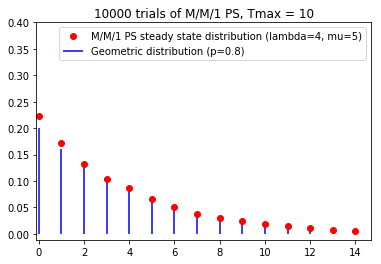

In [83]:
vlines(range(15),0,P[:15],colors='b',label="Geometric distribution (p=0.8)")
plot(range(15), Ns[:15],'ro',label="M/M/1 PS steady state distribution (lambda=4, mu=5)")
axis(xmin=-.1,ymax=.4)
title("10000 trials of M/M/1 PS, Tmax = 10")
legend()

In [48]:
x       = range(Imax+1)              # probability indices
##############################
# Define the steady state distribution of state k (k=0,1,...)
def p(k):
    return (1-ρ)*ρ**k
P       = [p(k) for k in x] # steady state pobabilities
##############################
subplot(211)
vlines(x,0,P,colors='b',label="Geometric distribution")
plot(x, P,'bx')
plot(x, P_est_T,'ro',label="Histogram at T=%ds"%Tmax)
axis(xmin=-.1,ymax=.25)
legend()
title("Distribution of the number of clients in the M/M/1 queue")
subplot(212)
vlines(x,0,P,colors='b',label="Geometric distribution")
plot(x, P,'bx')
plot(x, P_est_2T,'ro',label="Histogram at T=%ds"%(2*Tmax))
axis(xmin=-.1,ymax=.25)
legend()

[9,
 1,
 3,
 5,
 3,
 6,
 13,
 28,
 4,
 14,
 7,
 20,
 1,
 0,
 1,
 6,
 7,
 4,
 0,
 8,
 9,
 4,
 0,
 0,
 13,
 7,
 13,
 1,
 1,
 1,
 1,
 1,
 8,
 3,
 0,
 3,
 5,
 1,
 1,
 1,
 2,
 2,
 9,
 10,
 1,
 10,
 9,
 7,
 8,
 4,
 1,
 1,
 1,
 4,
 14,
 11,
 10,
 7,
 4,
 1,
 4,
 9,
 1,
 3,
 1,
 0,
 1,
 1,
 4,
 1,
 4,
 4,
 10,
 4,
 1,
 0,
 1,
 3,
 3,
 12,
 4,
 2,
 4,
 4,
 1,
 5,
 6,
 3,
 5,
 9,
 4,
 0,
 5,
 15,
 2,
 3,
 10,
 7,
 15,
 1]

In [185]:
# WRONG -- SHOULD NOT BE TWO QUEUES HERE

def MM1PS(C=3,lambd=4,mu=2.,N0=0,Tmax=100):
    T             = [0]  # list of times that events occur
    t_temp        = 0    # temporary time to calculate delta
    N             = [N0] # initial state of the system
    
    # remaining service time and arrival times of customers in service
    remaining_times = [customer() for k in range(C)]
    num_in_service = 0
    
    # times spent by users inside the system
    waiting_times = []
    
    # customers waiting for service to become available, by their arrival times
    queue = []
    
    # first event must be an arrival
    next_arrival = exp(lambd)
    next_departure = inf()
    
    #printarray(T)
    #printarray(N)
    while T[-1] < Tmax:
        t_temp = T[-1]
        if num_in_service > 0:
            remaining_times = [decrease_time_remaining(x, (T[-1]-t_temp)/num_in_service) for x in remaining_times]
        
        # arrival
        if next_arrival < next_departure:
            #print("Processing an arrival; next arrival %.3f next departure %.3f" %(next_arrival, next_departure))
            T.append(next_arrival)
            N.append(N[-1]+1)
            # if there is no free server, add the arrival to the queue
            if remaining_times[C - 1].service_time < inf():
                queue.append(T[-1])
            # otherwise, assign the customer to the server
            else:
                service_time = exp(mu)
                remaining_times.append(customer(service_time, service_time, T[-1]))
                remaining_times.sort(key=lambda x: x.time_remaining, reverse=False)
                num_in_service += 1
            next_arrival = T[-1] + exp(lambd)
            
            #print("Next Arrival %f" % (next_arrival))
        
        # departure
        else: 
            #print("Processing a departure; next arrival %.3f next departure %.3f" %(next_arrival, next_departure))
            T.append(next_departure)
            N.append(N[-1]-1)
            popped_customer = remaining_times.pop(0)
            
            # if there is no queue, the server is free
            if len(queue) == 0:
                remaining_times.append(customer())
                num_in_service -= 1
            # otherwise, take someone off the queue
            else:
                arrival_time = queue.pop(0)
                service_time = exp(mu)
                remaining_times.append(customer(service_time, service_time, arrival_time))
            remaining_times.sort(key=lambda x: x.time_remaining, reverse=False)
            
            print(popped_customer)
            # process the departure
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
        
        printarray(T)
        printarray(N)
        if N[-1] == 0:
            next_departure = inf()
        else:
            next_departure = T[-1] + remaining_times[0].time_remaining * num_in_service
        #print("Next Departure %f" % (next_departure))
        
    T  = T[:-1] # event after Tmax is discarded
    N  = N[:-1]
    return T,N,waiting_times